In [1]:
!pip3 install torchvision
import numpy as np
 
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, RNN, LSTM, GRU
from torch.nn.functional import softmax, relu, nll_loss, log_softmax
from torch import sigmoid, tanh

from sklearn.manifold import TSNE
import h5py
import matplotlib.pyplot as plt
from google.colab import files


    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 2.0MB 11.1MB/s 
    100% |████████████████████████████████| 591.8MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x60dc2000 @  0x7fed461ed2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
# Accessing google drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [4]:
# Load data from google drive, using colab
!pwd
with h5py.File('/content/drive/My Drive/Colab Notebooks/L4M_dataset.hdf5', 'r') as hf:
    data = hf['data'][:]
    label = hf['label'][:]

/content


In [6]:
seq = [] #Initalize
lab = []
current_user = -1
for i in range(data.shape[0]): # going through the data and sorting into user sequences
    if data[i,0]!=current_user:
        current_user = data[i,0]
        seq.append([data[i,1]])
        lab.append([label[i]])        
    else:
        seq[-1].append(data[i,1]) # new user line
        lab[-1].append(label[i])

choose_split = 0 #choosing the split that is going to be used, 0 for 1st split, and 1 for the 2nd

if choose_split==0:
    train_idx = np.random.choice(len(seq),(len(seq)*8)//10,replace = False)
    seq_train = [seq[i] for i in train_idx]
    seq_test = [seq[i] for i in range(len(seq)) if i not in train_idx]
    lab_train = [lab[i] for i in train_idx]
    lab_test = [lab[i] for i in range(len(lab)) if i not in train_idx]

    seq_train.sort(key=lambda x:len(x))
    lab_train.sort(key=lambda x:len(x))
    seq_test.sort(key=lambda x:len(x))
    lab_test.sort(key=lambda x:len(x))
    seq_train = [item for item in seq_train if len(item) > 19]
    lab_train = [item for item in lab_train if len(item) > 19]
    seq_test = [item for item in seq_test if len(item) > 19]
    lab_test = [item for item in lab_test if len(item) > 19]   
else:
    seq = [item for item in seq if len(item) > 39]
    lab = [item for item in lab if len(item) > 39]

    seq_train = [item[:-20] for item in seq]
    seq_test = [item[-20:] for item in seq]
    lab_train = [item[:-20] for item in lab]
    lab_test = [item[-20:] for item in lab]

    seq_train.sort(key=lambda x:len(x))
    lab_train.sort(key=lambda x:len(x))
    seq_test.sort(key=lambda x:len(x))
    lab_test.sort(key=lambda x:len(x))
    
seq_length_train = [len(x) for x in seq_train]
seq_length_test = [len(x) for x in seq_test]

print(len(seq_train))
print(len(seq_test))
print(len(lab_train))
print(len(lab_test))

120537
29979
120537
29979


In [7]:
# Define network
output_size = 17770
num_input = 17770
hidden_size_rnn = 500
hidden_size_lin1 = 5000

hidden_size_lin2 = 500

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.one_hot = nn.Embedding(num_input, num_input)
        self.one_hot.weight.data = torch.eye(num_input)
        self.one_hot.weight.detach_()
        
        self.rnn = GRU(input_size=num_input,
                        hidden_size=hidden_size_rnn,
                        num_layers=1,
                        bidirectional=False,
                        batch_first = True)
        
        self.lin1 = Linear(in_features=num_input,
                           out_features=hidden_size_lin1,
                           bias=False)
        
        
        self.lin2 = Linear(in_features=hidden_size_lin1,
                           out_features=hidden_size_lin2,
                           bias=False)
        
        self.l_out = Linear(in_features=hidden_size_rnn,
                            out_features=output_size,
                            bias=False)
        
        self.criteria = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(p = 0.4)
    
    def forward(self, x):
        out = {}
        x = self.one_hot(x)
        
        x, hn = self.rnn(x)
        
        #x = tanh(self.lin1(x))
        
        #x = self.dropout(x)
                
        #x = tanh(self.lin2(x))
        
        x = self.dropout(x)
        
        out = self.l_out(x)
        return out
    
net = Net()
if use_cuda:
    print('##converting network to cuda-enabled')
    net.cuda()
print(net)

##converting network to cuda-enabled
Net(
  (one_hot): Embedding(17770, 17770)
  (rnn): GRU(17770, 500, batch_first=True)
  (lin1): Linear(in_features=17770, out_features=5000, bias=False)
  (lin2): Linear(in_features=5000, out_features=500, bias=False)
  (l_out): Linear(in_features=500, out_features=17770, bias=False)
  (criteria): CrossEntropyLoss()
  (dropout): Dropout(p=0.4)
)


In [8]:
{p[0]: p[1].requires_grad for p in net.named_parameters()} #checking which weigth are updated,

{'l_out.weight': True,
 'lin1.weight': True,
 'lin2.weight': True,
 'one_hot.weight': False,
 'rnn.bias_hh_l0': True,
 'rnn.bias_ih_l0': True,
 'rnn.weight_hh_l0': True,
 'rnn.weight_ih_l0': True}

In [0]:
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [10]:
# Train and validation loop
batch_size = 50
net.train()
counter = 0
temp = 0

train_accuracy = []
test_accuracy = []
train_loss = []

for i in np.random.choice(len(seq_train)//batch_size,len(seq_train)//batch_size, replace=False):
    net.train()
    batch = seq_train[i*batch_size:(i+1)*batch_size]
    batch_length = seq_length_train[i*batch_size:(i+1)*batch_size]
    batch_label = lab_train[i*batch_size:(i+1)*batch_size]
    
    # Cutting the data to use only the last 20 movies of the sequence
    min_len_batch = min(batch_length)
    batch = np.array([item[-20:] for item in batch]) 
    batch_label = np.array([item[-20:] for item in batch_label])
    batch = torch.from_numpy(batch).long()
    batch_label = torch.from_numpy(batch_label).long()
    if use_cuda:
        batch = Variable(batch.cuda())
        batch_label = Variable(batch_label.cuda())
    output = net(batch)
    batch_loss = net.criteria(output.view(-1,output_size),batch_label.view(-1))
    temp = temp + batch_loss
    counter += 1
    every = 50
    if counter%every ==0:
        print('TRAIN Loss'+' '+str(counter)+':',temp/every)
        train_loss.append(temp/every)

        temp = 0

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()    
    
    # Train accuracy on rand_sample users from the training sequence 
    
    rand_samples = 1000
    if (counter % every) == 0:
        net.eval()
        count_train = 0
        good_train = 0
        with torch.no_grad():
            for user_train_idx in np.random.choice(range(len(seq_train)), rand_samples, replace = False):
                user_train = seq_train[user_train_idx]
                inputs_train = torch.from_numpy(np.array(user_train[-20:-5],dtype=float)).long()
                if use_cuda:
                    inputs_train = Variable(inputs_train.cuda())
                labels_train = user_train[-5:]
                inputs_train = inputs_train.view(1,inputs_train.size()[0])
                outputs_train = net(inputs_train)
                out_train = softmax(outputs_train[:,-1,:],dim=1).cpu().numpy().reshape(-1)

                top20_train = np.argsort(out_train)[-20:]
                okay_train = np.any([movie in labels_train for movie in top20_train])
                count_train += 1
                if okay_train:
                  good_train +=1
            print('TRAIN accuracy', good_train/rand_samples)
            train_accuracy.append(good_train/rand_samples)
    
    
    
    # Test Accuracy on rand_sample users from the test sequence
    #every_test = 50
    if (counter % every) == 0:
        net.eval()
        count_test = 0
        good_test = 0
        with torch.no_grad():
            for user_test_idx in np.random.choice(range(len(seq_test)),rand_samples, replace = False):
                user_test = seq_test[user_test_idx]
                inputs_test = torch.from_numpy(np.array(user_test[-20:-5],dtype=float)).long()
                if use_cuda:
                    inputs_test = Variable(inputs_test.cuda())
                labels_test = user_test[-5:]
                inputs_test = inputs_test.view(1,inputs_test.size()[0])
                outputs_test = net(inputs_test)
                out_test = softmax(outputs_test[:,-1,:],dim=1).cpu().numpy().reshape(-1)

                top20_test = np.argsort(out_test)[-20:]
                okay_test = np.any([movie in labels_test for movie in top20_test])
                count_test += 1
                if okay_test:
                    good_test +=1
            print('TEST accuracy', good_test/rand_samples)
            test_accuracy.append(good_test/rand_samples)


TRAIN Loss 50: tensor(7.9019, device='cuda:0', grad_fn=<DivBackward0>)
TRAIN accuracy 0.509
TEST accuracy 0.498
TRAIN Loss 100: tensor(6.8548, device='cuda:0', grad_fn=<DivBackward0>)
TRAIN accuracy 0.535
TEST accuracy 0.524
TRAIN Loss 150: tensor(6.5694, device='cuda:0', grad_fn=<DivBackward0>)
TRAIN accuracy 0.551
TEST accuracy 0.572
TRAIN Loss 200: tensor(6.4173, device='cuda:0', grad_fn=<DivBackward0>)
TRAIN accuracy 0.578
TEST accuracy 0.585
TRAIN Loss 250: tensor(6.2453, device='cuda:0', grad_fn=<DivBackward0>)
TRAIN accuracy 0.594
TEST accuracy 0.569
TRAIN Loss 300: tensor(6.2522, device='cuda:0', grad_fn=<DivBackward0>)
TRAIN accuracy 0.625
TEST accuracy 0.581
TRAIN Loss 350: tensor(6.1839, device='cuda:0', grad_fn=<DivBackward0>)
TRAIN accuracy 0.606
TEST accuracy 0.58
TRAIN Loss 400: tensor(6.2090, device='cuda:0', grad_fn=<DivBackward0>)
TRAIN accuracy 0.609
TEST accuracy 0.585
TRAIN Loss 450: tensor(6.0974, device='cuda:0', grad_fn=<DivBackward0>)
TRAIN accuracy 0.621
TEST 

In [11]:
# Evaluating the performance of the network using the whole test sequence
net.eval()
count = 0
good = 0
with torch.no_grad():
  for user in seq_test:
    
      inputs = torch.from_numpy(np.array(user[-20:-5],dtype=float)).long()
      if use_cuda:
          inputs = Variable(inputs.cuda())
      labels = user[-5:]
      inputs = inputs.view(1,inputs.size()[0])
      outputs = net(inputs)
      out = softmax(outputs[:,-1,:],dim=1).cpu().numpy().reshape(-1)
      #print(outputs.min(),outputs.max(),outputs.sum())
      #print(np.argmax(outputs))
      top20 = np.argsort(out)[-20:]
      okay = np.any([movie in labels for movie in top20])
      if count%1000==0:
        print(count)
      count += 1
      if okay:
        good +=1
print(good/count)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
0.6430834917775776


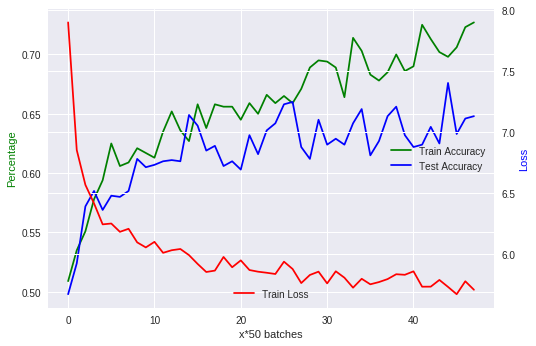

In [12]:
# Ploting the loss and accuracy
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(train_accuracy, 'g-',label = 'Train Accuracy')
ax1.plot(test_accuracy, 'b-', label = 'Test Accuracy')
ax1.legend(loc = 7)
ax2.plot(train_loss, 'r-',label = 'Train Loss')
ax2.legend(loc = 8)

ax1.set_xlabel('x*50 batches')
ax1.set_ylabel('Percentage', color='g')
ax2.set_ylabel('Loss', color='b')



plt.savefig('data1_500.png')
files.download("data1_500.png") 